# ML Assignment 1 - Canadian Hospital Re-admittance Challenge

*Harsh Kumar - IMT2021016* |
*Subhajeet Lahiri - IMT2021022* |
*Sai Madhavan G - IMT2021101*

**Note:** This file only contains unorganised, uncommented code for used for many of our submission attempts. To look at well-organized code for our approach, please look at *'./final.ipynb*

This contains many approaches and techniques that didn't make it to the final submission. We will document such approaches in more detail in our report.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.utils import class_weight, compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from joblib import dump, load
from icd9cms.icd9 import search as icdsearch
from sklearn.cluster import KMeans
from tqdm import tqdm
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
def mujhe_drugs_do(data, tt):

    def drug_changes(row):
        d = {"drug_up": 0, "drug_down": 0, "drug_steady":0}
        for drug in row:
            if drug=='Up':
                d['drug_up'] += 1
            elif drug=="Down":
                d['drug_down'] += 1
            elif drug=="Steady":
                d['drug_steady'] += 1
        return pd.Series(d)
    
    drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
    drugs_data = data[drugs]
    drug_change_df = drugs_data.apply(drug_changes, 1)
    data.drop(columns=drugs, inplace=True)
    if tt=='train':
        y = data['readmission_id']
        data.drop(columns=['readmission_id'], inplace=True)
        data = data.join(drug_change_df)
        data = data.join(y)
    elif tt=='test':
        data = data.join(drug_change_df)
    return data

In [3]:
def encode_cat(data, tt, cat_cols, enc):
    if tt=='train':
        encoded_data = pd.DataFrame(enc.fit_transform(data[cat_cols]), columns=cat_cols)
        for col in cat_cols:
            data[col] = encoded_data[col]
    elif tt=='test':
        encoded_data = pd.DataFrame(enc.transform(data[cat_cols]), columns=cat_cols)
        for col in cat_cols:
            data[col] = encoded_data[col]
    return data


In [4]:
def np_encode_cat(data, tt, cat_cols, enc):
    if tt=='train':
        encoded_data = enc.fit_transform(data[cat_cols].astype(str))
    elif tt=='test':
        encoded_data = enc.transform(data[cat_cols].astype(str))
    return encoded_data

In [5]:
def oe_encode_cat(data, tt, cat_cols, enc):
    if tt=='train':
        encoded_data = enc.fit_transform(data[cat_cols].astype(str)).toarray()
    elif tt=='test':
        encoded_data = enc.transform(data[cat_cols].astype(str)).toarray()
    return encoded_data

In [6]:
def drop_wt_a1c_mgs_ids(data):
    data.drop(columns=['weight', 'max_glu_serum', 'A1Cresult', 'enc_id', 'patient_id'], inplace=True)
    return data

In [7]:
def ms_and_pc(data, what_to_do):
    if what_to_do=='constant_impute':
        data['medical_specialty'] = data['medical_specialty'].fillna(68)
        data['payer_code'] = data['payer_code'].fillna(17)
    elif what_to_do=='drop':
        data.drop(columns=['medical_specialty', 'payer_code'], inplace=True)
    return data

In [8]:
def knn_impute(data, tt, imputer):
    if tt == "train":
        y = data['readmission_id']
        data = data.iloc[:, :data.shape[1]-1]
        imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
        imputed_data = imputed_data.join(y)
    elif tt == "test":
        imputed_data = pd.DataFrame(imputer.transform(data), columns=data.columns)
    return imputed_data

In [9]:
def get_X_y(data):
    X, y = data.iloc[:, :data.shape[1]-1].to_numpy(), data.iloc[:, data.shape[1]-1].to_numpy()
    return X, y

In [10]:
def cv(model, X, y, params = None):
    cv_results = cross_validate(model, X, y, scoring=['accuracy', 'f1_macro'], return_estimator=True, fit_params=params)
    return cv_results

In [11]:
def test_data_cleaning(test_data, ignore_diag=False):
    test_data.loc[test_data['medical_specialty']=='Surgery-PlasticwithinHeadandNeck', 'medical_specialty'] = 'Surgery-Plastic'
    test_data.loc[test_data['medical_specialty']=='SportsMedicine', 'medical_specialty'] = 'InternalMedicine'
    test_data.loc[test_data['medical_specialty']=='Pediatrics-InfectiousDiseases', 'medical_specialty'] = 'Pediatrics'
    test_data.loc[test_data['medical_specialty']=='Psychiatry-Addictive', 'medical_specialty'] = 'Psychiatry'
    if not ignore_diag:
        diag1_uk = ['955', '602', '834', '580', '879', '791', '988', 'E909', '48', '706', '543', 'V25', '817', '471', 'V70', '52', '684', '976', '372', '523', '325', '957', '365', '704', '207', '862', '363', '97', 'V51', '837', '334', '370']
        for val in diag1_uk:
            test_data.loc[test_data['diag_1']==val, 'diag_1'] = np.nan

        diag2_uk = ['V53', '88', '879', '734', 'E980', '364', '123', 'E945', '114', '871', '658', '953', '353', 'E829', '893', '754', '520', '906', '974', '863', '115', '140', '171', '942', '527', '52', '347', '96', 'V60', '605', 'E915', 'E868', 'V16', 'V69', '755', '912', '665', '927', '645', '615', '752', '232', '5', '962', '7', 'E890', '506', 'E817', '994', '945', '894', '271', '987', '748', '182', '795', '948']
        for val in diag2_uk:
            test_data.loc[test_data['diag_2']==val, 'diag_2'] = np.nan

        diag3_uk = ['955', '111', '602', '911', '879', 'E945', '123', '951', '674', '193', 'E966', '226', '943', '800', '308', '876', 'E955', '315', '236', '735', 'E828', '970', '158', '684', '757', 'E822', '877', '480', '755', 'E892', '890', '841', '448', 'E894', '935', '66', '854', '483', '17', '744', '370', '987', '387', '215']
        for val in diag3_uk:
            test_data.loc[test_data['diag_3']==val, 'diag_3'] = np.nan
    
    return test_data

In [12]:
def gen_submission(data, model, enc_ids, fname, xg=False, np=False):
    if not xg:
        if np:
            x = data
        else:
            x = data.to_numpy()
        preds = model.predict(x)
    else:
        x = xgb.DMatrix(data)
        preds = model.predict(x)
    if np:
        d = {'enc_id': enc_ids, 'readmission_id': preds}
        submission = pd.DataFrame(d)
    else:
        data['readmission_id'] = preds
        data['enc_id'] = enc_ids
        submission = data[['enc_id','readmission_id']]
    submission.loc[:, 'enc_id'] = submission['enc_id'].astype(int)
    submission.loc[:, 'readmission_id'] = submission['readmission_id'].astype(float)
    submission.to_csv(fname,index=False)

In [13]:
def pat_cnt(data, tt):
    vc = data['patient_id'].value_counts()
    pat_cnt = []
    for idx, row in data.iterrows():
        pat_cnt.append(vc[row['patient_id']])
    if tt=='train':
        data.insert(data.shape[1]-1, 'pat_cnt', pat_cnt)
    elif tt=='test':
        data.insert(data.shape[1], 'pat_cnt', pat_cnt)
    return data

In [1]:
def illegal_pat_cnt(data, test_data, tt):
    vc = pd.concat([data['patient_id'], test_data['patient_id']], axis=0).value_counts()
    pat_cnt = []
    for idx, row in data.iterrows():
        pat_cnt.append(vc[row['patient_id']])
    if tt=='train':
        data.insert(data.shape[1]-1, 'pat_cnt', pat_cnt)
    elif tt=='test':
        data.insert(data.shape[1], 'pat_cnt', pat_cnt)
    ss = StandardScaler()
    data['pat_cnt'] = ss.fit_transform(data['pat_cnt'].to_numpy().reshape(-1, 1))
    return data

In [15]:
def diag(df):
    diag_1=[]
    diag_2=[]
    diag_3=[]
    for idx, row in df.iterrows():
        d1 = str(row['diag_1'])
        if d1 == 'nan':
            diag_1.append(np.nan)
        else:
            if d1[0=='E']:
                d1 = d1[:4]
            elif len(d1)>3:
                d1 = d1[:3]
            v1 = f'{int(d1):03d}' if d1.isnumeric() else d1
            node = icdsearch(v1)
            if not node:
                print(v1, idx)
                break
            diag_1.append(str(node.parent))
        d2 = str(row['diag_2'])
        if d2 == 'nan':
            diag_2.append(np.nan)
        else:
            if d2[0=='E']:
                d2 = d2[:4]
            elif len(d2)>3:
                d2 = d2[:3]
            v2 = f'{int(d2):03d}' if d2.isnumeric() else d2
            node = icdsearch(v2)
            if not node:
                print(v2, idx)
                break
            diag_2.append(str(node.parent))
        d3 = str(row['diag_3'])
        if d3 == 'nan':
            diag_3.append(np.nan)
        else:
            if d3[0=='E']:
                d3 = d3[:4]
            elif len(d3)>3:
                d3 = d3[:3]
            v3 = f'{int(d3):03d}' if d3.isnumeric() else d3
            node = icdsearch(v3)
            if not node:
                print(v3, idx)
                break
            diag_3.append(str(node.parent))
    df['diag_1'] = diag_1
    df['diag_2'] = diag_2
    df['diag_3'] = diag_3
    return df

In [16]:
def diag_gp(df):
    diag_1=[]
    diag_2=[]
    diag_3=[]
    for idx, row in df.iterrows():
        d1 = str(row['diag_1'])
        if d1 == 'nan':
            diag_1.append(np.nan)
        else:
            if d1[0=='E']:
                d1 = d1[:4]
            elif len(d1)>3:
                d1 = d1[:3]
            v1 = f'{int(d1):03d}' if d1.isnumeric() else d1
            node = icdsearch(v1)
            if not node:
                print(v1, idx)
                break
            diag_1.append(str(node.parent.parent))
        d2 = str(row['diag_2'])
        if d2 == 'nan':
            diag_2.append(np.nan)
        else:
            if d2[0=='E']:
                d2 = d2[:4]
            elif len(d2)>3:
                d2 = d2[:3]
            v2 = f'{int(d2):03d}' if d2.isnumeric() else d2
            node = icdsearch(v2)
            if not node:
                print(v2, idx)
                break
            diag_2.append(str(node.parent.parent))
        d3 = str(row['diag_3'])
        if d3 == 'nan':
            diag_3.append(np.nan)
        else:
            if d3[0=='E']:
                d3 = d3[:4]
            elif len(d3)>3:
                d3 = d3[:3]
            v3 = f'{int(d3):03d}' if d3.isnumeric() else d3
            node = icdsearch(v3)
            if not node:
                print(v3, idx)
                break
            diag_3.append(str(node.parent.parent))
    df['diag_1'] = diag_1
    df['diag_2'] = diag_2
    df['diag_3'] = diag_3
    return df

In [17]:
def admission_type_map(data):
    admission_type_dict = {1: 0, 2:0, 7:0, 3: 1, 4: 2, 5: 3, 6:3, 8:3}
    admission_type_id = []
    for idx, row in data.iterrows():
        admission_type_id.append(admission_type_dict[row['admission_type_id']])
    data['admission_type_id'] = admission_type_id
    return data

In [18]:
def ddid_mapper(data, mapper):
    data['discharge_disposition_id'] = list(map(lambda x: mapper[x], data['discharge_disposition_id']))
    return data

In [19]:
def create_k_mappings(data, field, k):
    d={}
    for i in range(min(data[field]), max(data[field])+1):
        f = data.loc[data['discharge_disposition_id']==i]
        d[i] = (f['readmission_id'].value_counts()/len(f)*100)
    p = pd.DataFrame(d).transpose()
    kmeans = KMeans(k, n_init='auto')
    kmeans.fit(p.fillna(0))
    mapper = [None] * min(data[field]) +list(kmeans.labels_)
    return mapper

In [20]:
def generic_mapper(data, field, mapper):
    data[field] = list(map(lambda x: mapper[x], data[field]))
    return data

Globals

In [21]:
ENC_CAT_COLS = ['race', 'gender', 'age', 'weight','payer_code', 'medical_specialty','diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']
ENC_CAT_COLS_NO_DRUGS = ['race', 'gender', 'age','payer_code', 'medical_specialty','diag_1',
       'diag_2', 'diag_3', 'change', 'diabetesMed']
CAT_COLS = ['enc_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'payer_code', 'medical_specialty', 
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmission_id']
CAT_COLS_WITH_DIAG = ['race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmission_id']

## Attempt 3

In [23]:
data = pd.read_csv('./data/train.csv')
data = mujhe_drugs_do(data)
enc = OrdinalEncoder()
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = KNNImputer(n_neighbors=5)
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
gbc = GradientBoostingClassifier()
cv_res = cv(gbc, X, y)
cv_res

{'fit_time': array([42.28004694, 45.43473554, 43.70347047, 42.32045174, 42.28433847]),
 'score_time': array([0.075387  , 0.07605863, 0.0773828 , 0.07626438, 0.0770483 ]),
 'estimator': [GradientBoostingClassifier(),
  GradientBoostingClassifier(),
  GradientBoostingClassifier(),
  GradientBoostingClassifier(),
  GradientBoostingClassifier()],
 'test_accuracy': array([0.59355699, 0.58770267, 0.58636906, 0.5882642 , 0.5925458 ]),
 'test_f1_macro': array([0.40279113, 0.39424802, 0.39298684, 0.39394233, 0.40171012])}

## Attempt 4

HistGBC

In [45]:
data = pd.read_csv('./data/train.csv')
data = mujhe_drugs_do(data)
enc = OrdinalEncoder()
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = KNNImputer(n_neighbors=5)
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([2.6143012 , 2.80956912, 2.88971424, 2.86482811, 3.47302556]),
 'score_time': array([0.03610563, 0.0486629 , 0.0451529 , 0.04213881, 0.04664326]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, False,
                                                       False, False, False, True,
                                                       True, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                   

## Attempt 5

Adding pat_cnt

res: **62.9%**

In [47]:
data = pd.read_csv('./data/train.csv')
data = mujhe_drugs_do(data)
enc = OrdinalEncoder()
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = KNNImputer(n_neighbors=5)
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.47209501, 3.71905994, 3.09763432, 2.40079117, 3.25324297]),
 'score_time': array([0.04410172, 0.05475545, 0.03860855, 0.03307438, 0.04769492]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, False,
                                                       False, False, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                            

In [50]:
dump(cv_res['estimator'][0], '5_0.joblib')
model = cv_res['estimator'][0]
dump(enc, './models/62_9/enc_5_0.joblib')
dump(imputer, './models/62_9/imp_5_0.joblib')

In [62]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,...,369.0,600.0,441.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,...,269.0,302.0,244.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,...,269.0,369.0,237.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,...,252.0,602.0,140.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,269.0,249.0,244.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [63]:
gen_submission(test_data, model, enc_ids, 'submission_5.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 6

With ICD

res: **63.5%**

In [99]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([2.99288535, 3.09465599, 2.5856297 , 2.80226207, 2.63987279]),
 'score_time': array([0.06477141, 0.04709888, 0.05510688, 0.0400002 , 0.03900051]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [100]:
dump(cv_res['estimator'][3], '6_0.joblib')
model = cv_res['estimator'][3]
dump(enc, './enc_6_0.joblib')
dump(imputer, './imp_6_0.joblib')

['./imp_6_0.joblib']

In [101]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [102]:
gen_submission(test_data, model, enc_ids, 'submission_6.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 7

ICDS GP

res: **63.0%**

In [104]:
data = pd.read_csv('./data/train.csv')
data = diag_gp(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.61069536, 3.77339768, 3.01893091, 2.9555912 , 3.57130861]),
 'score_time': array([0.04199576, 0.04000282, 0.05598927, 0.05401182, 0.04100776]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [105]:
dump(cv_res['estimator'][0], '7_0.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_7_0.joblib')
dump(imputer, './imp_7_0.joblib')

['./imp_7_0.joblib']

In [106]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag_gp(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,...,7.0,13.0,10.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,...,5.0,6.0,5.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,...,5.0,8.0,5.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,...,5.0,13.0,15.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,5.0,5.0,5.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [107]:
gen_submission(test_data, model, enc_ids, 'submission_7.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 6.1

ICD no impute

res: **61.9%**

In [108]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([2.74881411, 2.880373  , 3.61046195, 2.88101578, 3.43314743]),
 'score_time': array([0.04416728, 0.04163027, 0.05574703, 0.05114484, 0.04870796]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [109]:
dump(cv_res['estimator'][0], '6_1.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_6_1.joblib')
dump(imputer, './imp_6_1.joblib')

['./imp_6_1.joblib']

In [110]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag_gp(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5,5,17,12,7.0,68.0,25,...,NaN,NaN,NaN,9,1.0,1.0,0,0,1,4
1,2.0,1.0,8.0,2,3,7,3,7.0,8.0,59,...,NaN,NaN,NaN,9,0.0,1.0,0,1,0,1
2,0.0,0.0,6.0,3,1,1,8,6.0,18.0,47,...,NaN,NaN,NaN,9,0.0,1.0,0,1,0,2
3,0.0,0.0,7.0,1,3,7,10,17.0,18.0,46,...,NaN,NaN,NaN,9,0.0,1.0,1,0,1,9
4,2.0,1.0,7.0,1,6,7,5,6.0,68.0,64,...,NaN,NaN,NaN,9,1.0,0.0,0,0,0,2


## Attempt 6.2

ICD no drugs

res: **63.1%**

In [120]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([5.63397598, 4.96364832, 4.70097232, 6.70218682, 7.63019013]),
 'score_time': array([0.05015421, 0.04210901, 0.04065776, 0.09685826, 0.09999418]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, ...]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                           

In [121]:
dump(cv_res['estimator'][0], '6_2.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_6_2.joblib')
dump(imputer, './imp_6_2.joblib')

['./imp_6_2.joblib']

In [124]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag_gp(test_data)
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0


In [125]:
gen_submission(test_data, model, enc_ids, 'submission_6_2.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 8.1

admission id map

res: **62.8%**

In [116]:
data = pd.read_csv('./data/train.csv')
data = admission_type_map(data)
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.07008672, 3.4010334 , 2.29741693, 3.20496416, 3.07777143]),
 'score_time': array([0.04462028, 0.06479836, 0.03459048, 0.06531239, 0.04225564]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [117]:
dump(cv_res['estimator'][0], '8_1.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_8_1.joblib')
dump(imputer, './imp_8_1.joblib')

['./imp_8_1.joblib']

In [118]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = admission_type_map(test_data)
test_data = diag_gp(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,3.0,5.0,17.0,12.0,7.0,68.0,25.0,...,43.0,44.0,26.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,0.0,3.0,7.0,3.0,7.0,8.0,59.0,...,43.0,44.0,26.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,1.0,1.0,1.0,8.0,6.0,18.0,47.0,...,43.0,44.0,26.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,0.0,3.0,7.0,10.0,17.0,18.0,46.0,...,43.0,44.0,26.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,0.0,6.0,7.0,5.0,6.0,68.0,64.0,...,43.0,44.0,26.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [119]:
gen_submission(test_data, model, enc_ids, 'submission_8_1.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 8.2.1

discharge_dispose_id feature reduction using 4 clusters

res: **63.2%**

In [30]:
data = pd.read_csv('./data/train.csv')
ddid_mappings = [None, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 3, 3, 1, 0, 0, 0, 3, 3, 2, 1, 0, 0, 0, 2, 0, 1, 2]
data = ddid_mapper(data, ddid_mappings)
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([2.77515268, 2.99376392, 2.80483961, 2.72646999, 2.92223954]),
 'score_time': array([0.04052472, 0.04199696, 0.04000592, 0.04299974, 0.04052377]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [32]:
dump(cv_res['estimator'][0], '8_2_1.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_8_2_1.joblib')
dump(imputer, './imp_8_2_1.joblib')

['./imp_8_2_1.joblib']

In [36]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = ddid_mapper(test_data, ddid_mappings)
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,0.0,17.0,12.0,7.0,68.0,25.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,0.0,7.0,3.0,7.0,8.0,59.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,0.0,1.0,8.0,6.0,18.0,47.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,0.0,7.0,10.0,17.0,18.0,46.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,0.0,7.0,5.0,6.0,68.0,64.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [37]:
gen_submission(test_data, model, enc_ids, 'submission_8_2_1.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 8.2.2

discharge_dispose_id feature reduction using 5 clusters

res: **63.3%**

In [26]:
data = pd.read_csv('./data/train.csv')
ddid_mappings = [None, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 2, 4, 2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1]
data = ddid_mapper(data, ddid_mappings)
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.24722648, 2.32779574, 3.30435514, 3.70547199, 2.41992044]),
 'score_time': array([0.04312634, 0.03566217, 0.0430882 , 0.04763317, 0.03607154]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [27]:
dump(cv_res['estimator'][0], '8_2_2.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_8_2_2.joblib')
dump(imputer, './imp_8_2_2.joblib')

['./imp_8_2_2.joblib']

In [28]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = ddid_mapper(test_data, ddid_mappings)
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,0.0,17.0,12.0,7.0,68.0,25.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,0.0,7.0,3.0,7.0,8.0,59.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,0.0,1.0,8.0,6.0,18.0,47.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,0.0,7.0,10.0,17.0,18.0,46.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,0.0,7.0,5.0,6.0,68.0,64.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [29]:
gen_submission(test_data, model, enc_ids, 'submission_8_2_2.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 8.2.3

discharge_dispose_id feature reduction using 3 clusters

In [24]:
data = pd.read_csv('./data/train.csv')
ddid_mappings = [None, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1]
data = ddid_mapper(data, ddid_mappings)
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.09705544, 2.55316114, 2.55681467, 2.48557615, 2.96840954]),
 'score_time': array([0.04214883, 0.03458214, 0.0374577 , 0.03657532, 0.04158282]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

## Attempt 8.2.4

discharge_dispose_id feature reduction using 6 clusters

In [25]:
data = pd.read_csv('./data/train.csv')
ddid_mappings = [None, 4, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 0, 0, 5, 4, 4, 4, 0, 0, 2, 1, 4, 1, 1, 2, 4, 5, 2]
data = ddid_mapper(data, ddid_mappings)
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.39894843, 2.9883256 , 3.14573574, 2.72659135, 3.03754354]),
 'score_time': array([0.05112624, 0.04160237, 0.04512167, 0.0381124 , 0.04209852]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

## Attempt 8.2.5

discharge_dispose_id feature reduction using 10 clusters

res: **62.5%**

In [38]:
data = pd.read_csv('./data/train.csv')
ddid_mappings = [None, 8, 8, 8, 8, 3, 6, 8, 8, 0, 9, 4, 0, 4, 4, 7, 1, 1, 8, 4, 4, 2, 3, 8, 6, 6, 2, 5, 7, 2]
data = ddid_mapper(data, ddid_mappings)
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.21101689, 3.0939486 , 2.82869291, 2.84237123, 2.71377325]),
 'score_time': array([0.05513239, 0.04411793, 0.04218292, 0.0416081 , 0.03913617]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [39]:
dump(cv_res['estimator'][0], '8_2_5.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_8_2_5.joblib')
dump(imputer, './imp_8_2_5.joblib')

['./imp_8_2_5.joblib']

In [40]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = ddid_mapper(test_data, ddid_mappings)
test_data = diag_gp(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,3.0,17.0,12.0,7.0,68.0,25.0,...,43.0,44.0,26.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,8.0,7.0,3.0,7.0,8.0,59.0,...,43.0,44.0,26.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,8.0,1.0,8.0,6.0,18.0,47.0,...,43.0,44.0,26.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,8.0,7.0,10.0,17.0,18.0,46.0,...,43.0,44.0,26.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,43.0,44.0,26.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [41]:
gen_submission(test_data, model, enc_ids, 'submission_8_2_5.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 8.2._

testing differnt values of k for clustering

In [48]:
def run(k):
    data = pd.read_csv('./data/train.csv')
    ddid_mappings = create_k_mappings(data, 'discharge_disposition_id', k)
    data = ddid_mapper(data, ddid_mappings)
    data = diag(data)
    data = mujhe_drugs_do(data, 'train')
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
    data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
    data = pat_cnt(data, 'train')
    data = drop_wt_a1c_mgs_ids(data)
    data = ms_and_pc(data, 'constant_impute')
    imputer = SimpleImputer(strategy='most_frequent')
    data = knn_impute(data, 'train', imputer)
    X, y = get_X_y(data)
    cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
    hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
    cv_res = cv(hgbc, X, y)
    return cv_res

In [ ]:
f1s = []
for i in tqdm(range(2, 29)):
    cv_res = run(i)
    f1s.append(cv_res['test_f1_macro'].mean())
    print(f1s)

<Axes: >

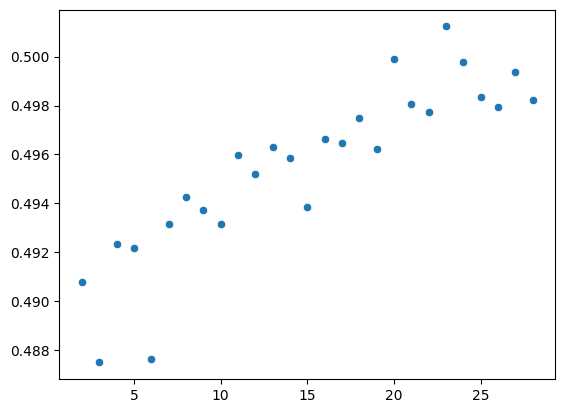

In [52]:
sns.scatterplot(y=f1s, x=list(range(2, 29)))

In [57]:
range(2, 29)[f1s.index(max(f1s))]

23

## Attempt 8.2.6

discharge_dispose_id feature reduction using 23 clusters

res: **63.2%**

In [58]:
data = pd.read_csv('./data/train.csv')
ddid_mappings = create_k_mappings(data, 'discharge_disposition_id', 23)
data = ddid_mapper(data, ddid_mappings)
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([2.8968997 , 2.90087771, 2.79673743, 3.3482008 , 2.72639489]),
 'score_time': array([0.04501271, 0.0455184 , 0.0449996 , 0.04799962, 0.04499912]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [59]:
dump(cv_res['estimator'][0], '8_2_6.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_8_2_6.joblib')
dump(imputer, './imp_8_2_6.joblib')

['./imp_8_2_6.joblib']

In [60]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = ddid_mapper(test_data, ddid_mappings)
test_data = diag_gp(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,2.0,17.0,12.0,7.0,68.0,25.0,...,43.0,44.0,26.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,11.0,7.0,3.0,7.0,8.0,59.0,...,43.0,44.0,26.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,14.0,1.0,8.0,6.0,18.0,47.0,...,43.0,44.0,26.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,11.0,7.0,10.0,17.0,18.0,46.0,...,43.0,44.0,26.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,16.0,7.0,5.0,6.0,68.0,64.0,...,43.0,44.0,26.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [61]:
gen_submission(test_data, model, enc_ids, 'submission_8_2_6.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 8.3._

Experimentig with different clusters for asid

In [67]:
def run(k):
    data = pd.read_csv('./data/train.csv')
    asid_mappings = create_k_mappings(data, 'admission_source_id', k)
    data = generic_mapper(data, 'admission_source_id', asid_mappings)
    data = diag(data)
    data = mujhe_drugs_do(data, 'train')
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
    data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
    data = pat_cnt(data, 'train')
    data = drop_wt_a1c_mgs_ids(data)
    data = ms_and_pc(data, 'constant_impute')
    imputer = SimpleImputer(strategy='most_frequent')
    data = knn_impute(data, 'train', imputer)
    X, y = get_X_y(data)
    cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
    hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
    cv_res = cv(hgbc, X, y)
    return cv_res

In [68]:
f1s = []
for i in tqdm(range(2, 26)):
    cv_res = run(i)
    f1s.append(cv_res['test_f1_macro'].mean())
    print(f1s)

  4%|▍         | 1/24 [00:51<19:39, 51.29s/it]

[0.49874959378961226]


  8%|▊         | 2/24 [01:42<18:41, 50.96s/it]

[0.49874959378961226, 0.4998967378681053]


 12%|█▎        | 3/24 [02:29<17:16, 49.36s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678]


 17%|█▋        | 4/24 [03:19<16:28, 49.43s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883]


 21%|██        | 5/24 [04:05<15:19, 48.40s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458]


 25%|██▌       | 6/24 [04:50<14:07, 47.11s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047]


 29%|██▉       | 7/24 [05:39<13:34, 47.90s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417]


 33%|███▎      | 8/24 [06:36<13:31, 50.75s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088]


 38%|███▊      | 9/24 [07:34<13:14, 52.99s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846]


 42%|████▏     | 10/24 [09:14<15:45, 67.53s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924]


 46%|████▌     | 11/24 [10:16<14:13, 65.68s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401]


 50%|█████     | 12/24 [11:17<12:52, 64.41s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228]


 54%|█████▍    | 13/24 [12:17<11:33, 63.03s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455]


 58%|█████▊    | 14/24 [13:13<10:08, 60.88s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605]


 62%|██████▎   | 15/24 [14:12<09:02, 60.29s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024]


 67%|██████▋   | 16/24 [15:11<08:00, 60.04s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402]


 71%|███████   | 17/24 [16:09<06:55, 59.30s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402, 0.49719933115226855]


 75%|███████▌  | 18/24 [17:11<06:00, 60.04s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402, 0.49719933115226855, 0.49927074883094286]


 79%|███████▉  | 19/24 [18:19<05:12, 62.49s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402, 0.49719933115226855, 0.49927074883094286, 0.49986218727234827]


 83%|████████▎ | 20/24 [19:21<04:09, 62.27s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402, 0.49719933115226855, 0.49927074883094286, 0.49986218727234827, 0.4984504382130913]


 88%|████████▊ | 21/24 [20:23<03:07, 62.36s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402, 0.49719933115226855, 0.49927074883094286, 0.49986218727234827, 0.4984504382130913, 0.4996720809775276]


 92%|█████████▏| 22/24 [21:26<02:05, 62.57s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402, 0.49719933115226855, 0.49927074883094286, 0.49986218727234827, 0.4984504382130913, 0.4996720809775276, 0.49891935758712763]


C:\Users\Sai Madhavan G\AppData\Local\Temp\ipykernel_38068\1363036273.py:8: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  kmeans.fit(p.fillna(0))
 96%|█████████▌| 23/24 [22:26<01:01, 61.71s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402, 0.49719933115226855, 0.49927074883094286, 0.49986218727234827, 0.4984504382130913, 0.4996720809775276, 0.49891935758712763, 0.49924578633543837]


C:\Users\Sai Madhavan G\AppData\Local\Temp\ipykernel_38068\1363036273.py:8: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  kmeans.fit(p.fillna(0))
100%|██████████| 24/24 [23:27<00:00, 58.63s/it]

[0.49874959378961226, 0.4998967378681053, 0.497654220027678, 0.4992105381264883, 0.4994935294070458, 0.4980800721149047, 0.49684911654655417, 0.4972167393406088, 0.4972962751076846, 0.4991806834040924, 0.4960358759651401, 0.5002754062422228, 0.4988815500627455, 0.49824748051230605, 0.4967259230108024, 0.4996593701474402, 0.49719933115226855, 0.49927074883094286, 0.49986218727234827, 0.4984504382130913, 0.4996720809775276, 0.49891935758712763, 0.49924578633543837, 0.4989638737448005]


<Axes: >

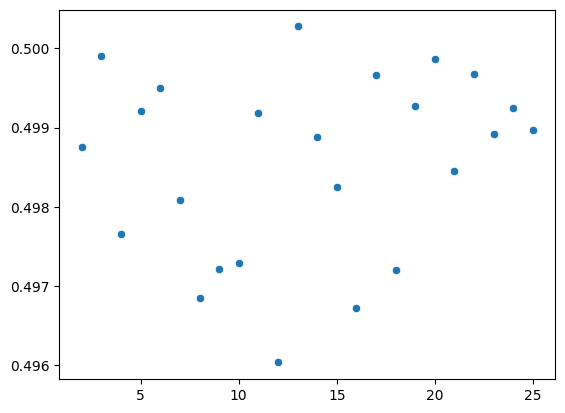

In [69]:
sns.scatterplot(y=f1s, x=list(range(2, 26)))

In [70]:
range(2, 26)[f1s.index(max(f1s))]

13

## Attempt 8.3.1

discharge_dispose_id feature reduction using 17 clusters

res: **63.0%**

In [71]:
data = pd.read_csv('./data/train.csv')
asid_mappings = create_k_mappings(data, 'admission_source_id', 13)
data = generic_mapper(data, 'admission_source_id', asid_mappings)
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.84746981, 3.32003736, 4.1163764 , 4.46514893, 3.2301991 ]),
 'score_time': array([0.05645442, 0.04977918, 0.06767392, 0.0599587 , 0.04269195]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                               

In [72]:
dump(cv_res['estimator'][0], '8_3_1.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_8_3_1.joblib')
dump(imputer, './imp_8_3_1.joblib')

['./imp_8_3_1.joblib']

In [74]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = generic_mapper(test_data, 'admission_source_id', asid_mappings)
test_data = diag_gp(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,12.0,12.0,7.0,68.0,25.0,...,43.0,44.0,26.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,0.0,3.0,7.0,8.0,59.0,...,43.0,44.0,26.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,1.0,10.0,8.0,6.0,18.0,47.0,...,43.0,44.0,26.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,3.0,0.0,10.0,17.0,18.0,46.0,...,43.0,44.0,26.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,0.0,5.0,6.0,68.0,64.0,...,43.0,44.0,26.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [75]:
gen_submission(test_data, model, enc_ids, 'submission_8_3_1.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 9

XGboost try

res: **63.1%**

In [25]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y)
xg_train = xgb.DMatrix(train_X, label=train_y)
xg_test = xgb.DMatrix(test_X, label=test_y)

In [31]:
param = {}
param['device'] = 'cuda'
param['eta'] = 0.3
param['max_depth'] = 6
param['nthread'] = 4
param['num_class'] = 3
param['objective'] = 'multi:softmax'
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 30
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-mlogloss:0.96319	test-mlogloss:0.96627
[1]	train-mlogloss:0.88381	test-mlogloss:0.88925
[2]	train-mlogloss:0.83344	test-mlogloss:0.84124
[3]	train-mlogloss:0.80081	test-mlogloss:0.81088
[4]	train-mlogloss:0.77856	test-mlogloss:0.79086
[5]	train-mlogloss:0.76295	test-mlogloss:0.77736
[6]	train-mlogloss:0.75111	test-mlogloss:0.76780
[7]	train-mlogloss:0.74203	test-mlogloss:0.76076
[8]	train-mlogloss:0.73505	test-mlogloss:0.75594
[9]	train-mlogloss:0.72903	test-mlogloss:0.75222
[10]	train-mlogloss:0.72399	test-mlogloss:0.74964
[11]	train-mlogloss:0.71965	test-mlogloss:0.74745
[12]	train-mlogloss:0.71595	test-mlogloss:0.74582
[13]	train-mlogloss:0.71303	test-mlogloss:0.74464
[14]	train-mlogloss:0.70976	test-mlogloss:0.74321
[15]	train-mlogloss:0.70713	test-mlogloss:0.74225
[16]	train-mlogloss:0.70448	test-mlogloss:0.74158
[17]	train-mlogloss:0.70202	test-mlogloss:0.74086
[18]	train-mlogloss:0.70010	test-mlogloss:0.74044
[19]	train-mlogloss:0.69826	test-mlogloss:0.74003
[20]	train

In [32]:
pred = bst.predict(xg_test)
error_rate = np.sum(pred != test_y) / test_y.shape[0]
print('Test error using softmax = {}'.format(error_rate))
print('Accuracy score using softmax = {}'.format(accuracy_score(test_y, pred)))
print('f1 macro score using softmax = {}'.format(f1_score(test_y, pred, average='macro')))

Test error using softmax = 0.3090010668762985
Accuracy score using softmax = 0.6909989331237015
f1 macro score using softmax = 0.4984720046129642


In [33]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,3.0,29.0,0.0,0.0,4.0,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,0.0,24.0,0.0,1.0,0.0,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,0.0,23.0,0.0,0.0,0.0,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,6.0,38.0,0.0,2.0,7.0,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,1.0,16.0,0.0,0.0,1.0,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [37]:
gen_submission(test_data, bst, enc_ids, 'submission_9.csv', True)

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 10

Grid search for hyperparameters in HistGBC

In [25]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
model = HistGradientBoostingClassifier(categorical_features=cat_feat)
param_grid = {
    'max_iter': [1000,1200,1500],
 'learning_rate': [0.1],
 'max_depth' : [25, 50, 75],
 'l2_regularization': [1.5],
 'scoring': ['f1_macro'],
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=8, cv=5, scoring='f1_macro', refit=True)
model_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            False,
                                                                            True,
                                                                            True,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            False,
                                                                            True,
                                                                            True,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            False]),
             n_jobs=8,
             param_grid={'l2_regularization': [1.5], 'learning_rate': [0.1],
                         'max_depth': [25, 50, 75],
                         'max_iter': [1000, 1200, 1500],
                         'scoring': ['f1_macro']},
             scoring='f1_macro')

In [26]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_regularization,param_learning_rate,param_max_depth,param_max_iter,param_scoring,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,15.242333,3.179192,0.317341,0.044232,1.5,0.1,25,1200,f1_macro,"{'l2_regularization': 1.5, 'learning_rate': 0....",0.510707,0.501428,0.505727,0.504229,0.501655,0.504749,0.003386,1
0,14.379440,2.426705,0.303287,0.032535,1.5,0.1,25,1000,f1_macro,"{'l2_regularization': 1.5, 'learning_rate': 0....",0.514029,0.496246,0.506246,0.505198,0.500110,0.504366,0.006027,2
5,12.175140,4.636097,0.286622,0.054387,1.5,0.1,50,1500,f1_macro,"{'l2_regularization': 1.5, 'learning_rate': 0....",0.508448,0.501116,0.505529,0.503301,0.498012,0.503281,0.003583,3
2,14.067247,4.267218,0.302404,0.052330,1.5,0.1,25,1500,f1_macro,"{'l2_regularization': 1.5, 'learning_rate': 0....",0.503012,0.501854,0.506858,0.501121,0.501331,0.502835,0.002116,4
8,10.696757,1.734242,0.201988,0.007724,1.5,0.1,75,1500,f1_macro,"{'l2_regularization': 1.5, 'learning_rate': 0....",0.508699,0.496981,0.502441,0.504193,0.501802,0.502823,0.003787,5


In [27]:
model = model_grid_search.best_estimator_

In [28]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [29]:
gen_submission(test_data, model, enc_ids, 'submission_10.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 11

RF classifier

In [22]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
rf = RandomForestClassifier()
cv_res = cv(rf, X, y)
cv_res

{'fit_time': array([14.50620127, 14.07449126, 14.11599469, 14.85938168, 14.4453342 ]),
 'score_time': array([0.44052982, 0.46079135, 0.43194747, 0.4420073 , 0.44610929]),
 'estimator': [RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier()],
 'test_accuracy': array([0.69195677, 0.68617955, 0.68498631, 0.69698884, 0.68231908]),
 'test_f1_macro': array([0.49236698, 0.48634012, 0.48003594, 0.50082548, 0.48170207])}

In [23]:
dump(cv_res['estimator'][3], '11.joblib')
model = cv_res['estimator'][3]
dump(enc, './enc_11.joblib')
dump(imputer, './imp_11.joblib')

['./imp_11.joblib']

In [24]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [25]:
gen_submission(test_data, model, enc_ids, 'submission_11.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 6.5

Whole data

res: **63.4%**

In [29]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
data = drop_wt_a1c_mgs_ids(data)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
model = HistGradientBoostingClassifier(categorical_features=cat_feat)
model.fit(X, y)

HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                     True, True, False, True,
                                                     True, False, False, False,
                                                     False, False, False, True,
                                                     True, True, False, True,
                                                     True, False, False, False,
                                                     False])

In [30]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data = drop_wt_a1c_mgs_ids(test_data)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [31]:
gen_submission(test_data, model, enc_ids, 'submission_6_5.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 12

not dropping encid

with scaling: **64%**
without scaling: **63.9%**

In [40]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
# data = drop_wt_a1c_mgs_ids(data)
data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id'], inplace=True)
# ss = StandardScaler()
# data['enc_id'] = ss.fit_transform(data['enc_id'].to_numpy().reshape(-1, 1))
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.31517792, 3.02797556, 3.02362895, 3.30236125, 3.5222106 ]),
 'score_time': array([0.04652023, 0.04052234, 0.04199815, 0.04552197, 0.04600239]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[False, True, True, True,
                                                       True, True, True, False,
                                                       True, True, False, False,
                                                       False, False, False, False,
                                                       True, True, True, False,
                                                       True, True, False, False,
                                                       False, False]),
  HistGradientBoostingClassifier(categorical_features=[False, True, True, True,
                                                       True, True, True, False,
                                                       True, True, False, False,
                        

In [41]:
dump(cv_res['estimator'][0], '12.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_12.joblib')
dump(imputer, './imp_12.joblib')

['./imp_12.joblib']

In [43]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
# test_data = drop_wt_a1c_mgs_ids(test_data)
test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id'], inplace=True)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,enc_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,86305392.0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,394919696.0,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,164917446.0,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,178319040.0,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,253585416.0,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [44]:
gen_submission(test_data, model, enc_ids, 'submission_12_1.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 13

not dropping patid

With scaling: **63.9%**
Without scaling: **63.9%**
Scaling pat_cnt: **64.3%**

In [77]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
ss3 = StandardScaler()
data['pat_cnt'] = ss3.fit_transform(data['pat_cnt'].to_numpy().reshape(-1, 1))
# data = drop_wt_a1c_mgs_ids(data)
data.drop(columns=['weight', 'max_glu_serum','A1Cresult'], inplace=True)
ss1 = StandardScaler()
data['enc_id'] = ss1.fit_transform(data['enc_id'].to_numpy().reshape(-1, 1))
# ss2 = StandardScaler()
# data['patient_id'] = ss2.fit_transform(data['patient_id'].to_numpy().reshape(-1, 1))
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.93884325, 3.66308951, 3.41257143, 3.53375769, 3.82713246]),
 'score_time': array([0.07751536, 0.04399872, 0.04752088, 0.07254267, 0.06553626]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[False, False, True, True,
                                                       True, True, True, True,
                                                       False, True, True, False,
                                                       False, False, False, False,
                                                       False, True, True, True,
                                                       False, True, True, False,
                                                       False, False, False]),
  HistGradientBoostingClassifier(categorical_features=[False, False, True, True,
                                                       True, True, True, True,
                                                       False, True, True, False,
                 

In [78]:
dump(cv_res['estimator'][0], '13.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_13.joblib')
dump(imputer, './imp_13.joblib')

['./imp_13.joblib']

In [79]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data['pat_cnt'] = ss3.transform(test_data['pat_cnt'].to_numpy().reshape(-1, 1))
# test_data = drop_wt_a1c_mgs_ids(test_data)
test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult'], inplace=True)
test_data['enc_id'] = ss1.transform(test_data['enc_id'].to_numpy().reshape(-1, 1))
# test_data['patient_id'] = ss2.transform(test_data['patient_id'].to_numpy().reshape(-1, 1))
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,enc_id,patient_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,-0.767896,23846112.0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,1.165750
1,2.236773,90620001.0,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,-0.486197
2,-0.002529,25342173.0,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,0.064452
3,0.127949,23481783.0,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,3.918996
4,0.860742,86500791.0,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,0.064452


In [80]:
gen_submission(test_data, model, enc_ids, 'submission_13_2.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 14

race

dropping: **63.8%**
constant_impute: **63.7%**
ohe: **63.6%**

In [66]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
# data = drop_wt_a1c_mgs_ids(data)
data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id'], inplace=True)
ss1 = StandardScaler()
data['enc_id'] = ss1.fit_transform(data['enc_id'].to_numpy().reshape(-1, 1))
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)

oh_race = pd.get_dummies(data['race'])
data.drop(columns='race', inplace=True)
data = pd.concat([oh_race, data], axis=1)

X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.73480463, 3.8231957 , 3.36582994, 4.69228649, 3.03822613]),
 'score_time': array([0.04651165, 0.04951859, 0.04351759, 0.07601643, 0.04100108]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[False, False, False, False,
                                                       False, False, True, True,
                                                       True, True, True, False,
                                                       True, True, False, False,
                                                       False, False, False, False,
                                                       True, True, True, False,
                                                       True, True, False, False,
                                                       False, False]),
  HistGradientBoostingClassifier(categorical_features=[False, False, False, False,
                                                       False, False, True, True,
                 

In [67]:
dump(cv_res['estimator'][0], '14_2.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_14_2.joblib')
dump(imputer, './imp_14_2.joblib')

['./imp_14_2.joblib']

In [70]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
# test_data = drop_wt_a1c_mgs_ids(test_data)
test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id'], inplace=True)
test_data['enc_id'] = ss1.transform(test_data['enc_id'].to_numpy().reshape(-1, 1))
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)

oh_race = pd.get_dummies(test_data['race'])
test_data.drop(columns='race', inplace=True)
test_data = pd.concat([oh_race, test_data], axis=1)

test_data.head()

,0.0,1.0,2.0,3.0,4.0,enc_id,gender,age,admission_type_id,discharge_disposition_id,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,0,0,1,0,0,-0.767896,1.0,4.0,5.0,5.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,0,0,1,0,0,2.236773,1.0,8.0,2.0,3.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1,0,0,0,0,-0.002529,0.0,6.0,3.0,1.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,1,0,0,0,0,0.127949,0.0,7.0,1.0,3.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,0,0,1,0,0,0.860742,1.0,7.0,1.0,6.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [71]:
gen_submission(test_data, model, enc_ids, 'submission_14_2.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 15

gender

**dropping: 63.9%**

In [72]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
# data = drop_wt_a1c_mgs_ids(data)
data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id', 'gender'], inplace=True)
ss = StandardScaler()
data['enc_id'] = ss.fit_transform(data['enc_id'].to_numpy().reshape(-1, 1))
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([4.71442986, 3.22915673, 3.27005792, 4.06890845, 2.95865941]),
 'score_time': array([0.05853081, 0.11352158, 0.05552244, 0.04751873, 0.05752492]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[False, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False, False, False, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                                                       False]),
  HistGradientBoostingClassifier(categorical_features=[False, True, True, True,
                                                       True, True, False, True,
                                                       True, False, False, False,
                             

In [73]:
dump(cv_res['estimator'][0], '15_0.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_15_0.joblib')
dump(imputer, './imp_15_0.joblib')

['./imp_15_0.joblib']

In [74]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
# test_data = drop_wt_a1c_mgs_ids(test_data)
test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id', 'gender'], inplace=True)
test_data['enc_id'] = ss.transform(test_data['enc_id'].to_numpy().reshape(-1, 1))
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,enc_id,race,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,-0.767896,2.0,4.0,5.0,5.0,17.0,12.0,7.0,68.0,25.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,4.0
1,2.236773,2.0,8.0,2.0,3.0,7.0,3.0,7.0,8.0,59.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-0.002529,0.0,6.0,3.0,1.0,1.0,8.0,6.0,18.0,47.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.127949,0.0,7.0,1.0,3.0,7.0,10.0,17.0,18.0,46.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,9.0
4,0.860742,2.0,7.0,1.0,6.0,7.0,5.0,6.0,68.0,64.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,2.0


In [75]:
gen_submission(test_data, model, enc_ids, 'submission_15_0.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 16

Scaling everything

res: **63%**

In [87]:
data = pd.read_csv('./data/train.csv')

data = pat_cnt(data, 'train')
data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id'], inplace=True)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)

y = data['readmission_id'].to_numpy()

data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
cat_data = np_encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)

ss = StandardScaler()
num_cols = [col for col in data.columns if col not in CAT_COLS_WITH_DIAG]
num_data = ss.fit_transform(data[num_cols])

X = np.concatenate([cat_data, num_data], 1)

X.shape, y.shape

((71236, 23), (71236,))

In [88]:
cat_feat = [True]*cat_data.shape[1] + [False]*num_data.shape[1]
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([3.57622313, 2.90305114, 2.62681508, 3.00377822, 3.05857277]),
 'score_time': array([0.04800129, 0.06453896, 0.0420053 , 0.04651356, 0.04399562]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, False, False,
                                                       False, False, False, False,
                                                       False, False, False, False,
                                                       False, False, False]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, False, False,
                                                       False, False, False, False,
                

In [91]:
dump(cv_res['estimator'][0], '16.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_16.joblib')
dump(imputer, './imp_16.joblib')

['./imp_16.joblib']

In [94]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']

test_data = pat_cnt(test_data, 'test')
test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id'], inplace=True)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)

test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
cat_test_data = np_encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)

num_cols = [col for col in test_data.columns if col not in CAT_COLS_WITH_DIAG]
num_test_data = ss.transform(test_data[num_cols])

x = np.concatenate([cat_test_data, num_test_data], 1)

x.shape

(30530, 23)

In [97]:
gen_submission(x, model, enc_ids, 'submission_16.csv', np=True)

## Attempt 17

RF GridSearch

Thanks to Deep

res: **64.1%**

In [21]:
data = pd.read_csv('./data/train.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = pat_cnt(data, 'train')
ss3 = StandardScaler()
data['pat_cnt'] = ss3.fit_transform(data['pat_cnt'].to_numpy().reshape(-1, 1))
data.drop(columns=['weight', 'max_glu_serum','A1Cresult'], inplace=True)
ss1 = StandardScaler()
data['enc_id'] = ss1.fit_transform(data['enc_id'].to_numpy().reshape(-1, 1))
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
X.shape, y.shape

((71236, 27), (71236,))

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, scoring='f1_macro', random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [24]:
dump(rf_random, 'rfrcv.joblib')

['rfrcv.joblib']

In [26]:
cv_results = pd.DataFrame(rf_random.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,450.514892,12.746783,14.271176,0.429755,2000,2,2,auto,50,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.506624,0.502836,0.501805,0.503755,0.002072,1
2,163.580205,2.863509,6.122101,0.146744,600,2,2,auto,60,False,"{'n_estimators': 600, 'min_samples_split': 2, ...",0.508444,0.500275,0.502325,0.503681,0.003470,2
5,105.909203,2.065345,3.691321,0.231231,400,10,1,sqrt,60,False,"{'n_estimators': 400, 'min_samples_split': 10,...",0.507021,0.498673,0.501613,0.502436,0.003458,3
4,268.183981,0.806252,9.689153,0.037083,1000,10,1,auto,80,False,"{'n_estimators': 1000, 'min_samples_split': 10...",0.505119,0.499456,0.501030,0.501868,0.002387,4
3,297.225589,3.533473,12.136833,0.033409,1400,5,1,sqrt,30,True,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.501226,0.493792,0.494968,0.496662,0.003262,5


In [27]:
model = rf_random.best_estimator_

In [29]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = pat_cnt(test_data, 'test')
test_data['pat_cnt'] = ss3.transform(test_data['pat_cnt'].to_numpy().reshape(-1, 1))
# test_data = drop_wt_a1c_mgs_ids(test_data)
test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult'], inplace=True)
test_data['enc_id'] = ss1.transform(test_data['enc_id'].to_numpy().reshape(-1, 1))
# test_data['patient_id'] = ss2.transform(test_data['patient_id'].to_numpy().reshape(-1, 1))
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,enc_id,patient_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,-0.767896,23846112.0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,1.165750
1,2.236773,90620001.0,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,-0.486197
2,-0.002529,25342173.0,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,0.064452
3,0.127949,23481783.0,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,3.918996
4,0.860742,86500791.0,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,0.064452


In [30]:
gen_submission(test_data, model, enc_ids, 'submission_17.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 18

OHE

rf: **62.9%**

In [31]:
data = pd.read_csv('./data/train.csv')

data = pat_cnt(data, 'train')
data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id'], inplace=True)
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)

y = data['readmission_id'].to_numpy()

data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OneHotEncoder(handle_unknown='ignore')
cat_data = oe_encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)

num_cols = [col for col in data.columns if col not in CAT_COLS_WITH_DIAG]
num_data = data[num_cols]

X = np.concatenate([cat_data, num_data], 1)

X.shape, y.shape

((71236, 497), (71236,))

In [32]:
rf = RandomForestClassifier()
cv_res = cv(rf, X, y)
cv_res

{'fit_time': array([36.67227936, 36.05043483, 35.82012296, 36.05948853, 36.1117475 ]),
 'score_time': array([1.05318451, 1.06187725, 1.05682158, 1.06196141, 1.06645203]),
 'estimator': [RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier()],
 'test_accuracy': array([0.68507861, 0.67544044, 0.6778971 , 0.68196813, 0.67522987]),
 'test_f1_macro': array([0.47735614, 0.47031873, 0.4706356 , 0.47797154, 0.46884461])}

In [36]:
cat_feat = [True]*cat_data.shape[1] + [False]*num_data.shape[1]
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res_hbgc = cv(hgbc, X, y)
cv_res_hbgc

{'fit_time': array([90.00185943, 83.44683361, 68.38405204, 61.27542639, 85.67331862]),
 'score_time': array([0.38853025, 0.37156343, 0.34855151, 0.31167197, 0.3928988 ]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, True, True,
                                                       True, True, ...]),
  HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                       True, True, True, True,
                               

In [37]:
model = cv_res_hbgc['estimator'][0]

In [38]:
test_data = pd.read_csv('./data/test.csv')
enc_ids = test_data['enc_id']

test_data = pat_cnt(test_data, 'test')
test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult', 'patient_id'], inplace=True)
test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)

test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
cat_test_data = oe_encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)

num_cols = [col for col in test_data.columns if col not in CAT_COLS_WITH_DIAG]
num_test_data = test_data[num_cols]

x = np.concatenate([cat_test_data, num_test_data], 1)

x.shape

(30530, 497)

In [39]:
gen_submission(x, model, enc_ids, 'submission_18_0.csv', np=True)

## Attempt 19

Illegal pat_cnt

In [24]:
data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = illegal_pat_cnt(data, test_data, 'train')
ss3 = StandardScaler()
data['pat_cnt'] = ss3.fit_transform(data['pat_cnt'].to_numpy().reshape(-1, 1))
data.drop(columns=['weight', 'max_glu_serum','A1Cresult'], inplace=True)
ss1 = StandardScaler()
data['enc_id'] = ss1.fit_transform(data['enc_id'].to_numpy().reshape(-1, 1))
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
hgbc = HistGradientBoostingClassifier(categorical_features=cat_feat)
cv_res = cv(hgbc, X, y)
cv_res

{'fit_time': array([4.24550104, 4.05612206, 5.83101583, 5.16723776, 4.79662228]),
 'score_time': array([0.05114651, 0.0702455 , 0.1247766 , 0.09502959, 0.07824969]),
 'estimator': [HistGradientBoostingClassifier(categorical_features=[False, False, True, True,
                                                       True, True, True, True,
                                                       False, True, True, False,
                                                       False, False, False, False,
                                                       False, True, True, True,
                                                       False, True, True, False,
                                                       False, False, False]),
  HistGradientBoostingClassifier(categorical_features=[False, False, True, True,
                                                       True, True, True, True,
                                                       False, True, True, False,
                 

In [25]:
dump(cv_res['estimator'][0], '13.joblib')
model = cv_res['estimator'][0]
dump(enc, './enc_19.joblib')
dump(imputer, './imp_19.joblib')

['./imp_19.joblib']

In [26]:
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = illegal_pat_cnt(test_data, data, 'test')
test_data['pat_cnt'] = ss3.transform(test_data['pat_cnt'].to_numpy().reshape(-1, 1))

test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult'], inplace=True)
test_data['enc_id'] = ss1.transform(test_data['enc_id'].to_numpy().reshape(-1, 1))

test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,enc_id,patient_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,-0.767896,23846112.0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,1.937363
1,2.236773,90620001.0,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,-0.514042
2,-0.002529,25342173.0,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,0.303093
3,0.127949,23481783.0,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,3.980200
4,0.860742,86500791.0,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,0.711661


In [27]:
gen_submission(test_data, model, enc_ids, 'submission_19.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Attempt 20

Hyperparameter tuning

In [24]:
data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
data = diag(data)
data = mujhe_drugs_do(data, 'train')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
data = encode_cat(data, 'train', ENC_CAT_COLS_NO_DRUGS, enc)
data = illegal_pat_cnt(data, test_data, 'train')
ss3 = StandardScaler()
data['pat_cnt'] = ss3.fit_transform(data['pat_cnt'].to_numpy().reshape(-1, 1))
data.drop(columns=['weight', 'max_glu_serum','A1Cresult'], inplace=True)
ss1 = StandardScaler()
data['enc_id'] = ss1.fit_transform(data['enc_id'].to_numpy().reshape(-1, 1))
data = ms_and_pc(data, 'constant_impute')
imputer = SimpleImputer(strategy='most_frequent')
data = knn_impute(data, 'train', imputer)
X, y = get_X_y(data)
cat_feat = list(map(lambda x: x in CAT_COLS_WITH_DIAG, data.columns.tolist()[:-1]))
model = HistGradientBoostingClassifier(categorical_features=cat_feat)
param_distributions = {
    'max_iter': [100, 1000, 3000],
    'max_leaf_nodes' : [10, 50, 100],
    'min_samples_leaf': [20, 50, 10],
   'l2_regularization': [0, 1, 1.5],
    'scoring': ['f1_macro'],
}
model_grid_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_jobs=-1, cv=3, scoring='f1_macro', n_iter=30)
model_grid_search.fit(X, y)

RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingClassifier(categorical_features=[False,
                                                                                  False,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  False,
                                                                                  True,
                                                                                  True,
                                                                                  False,
                                                                                  False,
                                                                                  False,
                                                                                  False,
                                                                                  False,
                                                                                  False,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  False,
                                                                                  True,
                                                                                  True,
                                                                                  False,
                                                                                  False,
                                                                                  False,
                                                                                  False]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'l2_regularization': [0, 1, 1.5],
                                        'max_iter': [100, 1000, 3000],
                                        'max_leaf_nodes': [10, 50, 100],
                                        'min_samples_leaf': [20, 50, 10],
                                        'scoring': ['f1_macro']},
                   scoring='f1_macro')

In [25]:
dump(model_grid_search, '20.joblib')

['20.joblib']

In [26]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scoring,param_min_samples_leaf,param_max_leaf_nodes,param_max_iter,param_l2_regularization,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
29,24.893247,9.727939,0.737903,0.188623,f1_macro,10,100,1000,0,"{'scoring': 'f1_macro', 'min_samples_leaf': 10...",0.559760,0.550321,0.558420,0.556167,0.004170,1
20,22.916166,5.870092,0.986890,0.158635,f1_macro,20,100,1000,1.5,"{'scoring': 'f1_macro', 'min_samples_leaf': 20...",0.560931,0.549146,0.557550,0.555876,0.004955,2
28,21.492809,3.828867,0.695310,0.077196,f1_macro,10,100,3000,1,"{'scoring': 'f1_macro', 'min_samples_leaf': 10...",0.552883,0.553271,0.558226,0.554793,0.002433,3
8,30.852198,13.259167,1.188810,0.328278,f1_macro,50,100,100,1.5,"{'scoring': 'f1_macro', 'min_samples_leaf': 50...",0.555480,0.552249,0.556300,0.554677,0.001749,4
19,19.521539,4.652876,0.883300,0.161197,f1_macro,50,100,3000,0,"{'scoring': 'f1_macro', 'min_samples_leaf': 50...",0.551919,0.554742,0.557028,0.554563,0.002090,5


In [27]:
param_grid = {
    'max_iter': [1000, 3000],
    'max_leaf_nodes' : [100, 150, 200],
    'min_samples_leaf': [20, 10],
   'l2_regularization': [0, 1.5],
    'scoring': ['f1_macro'],
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1_macro')
model_grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=HistGradientBoostingClassifier(categorical_features=[False,
                                                                            False,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            False,
                                                                            True,
                                                                            True,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            False,
                                                                            True,
                                                                            True,
                                                                            False,
                                                                            False,
                                                                            False,
                                                                            False]),
             n_jobs=-1,
             param_grid={'l2_regularization': [0, 1.5],
                         'max_iter': [1000, 3000],
                         'max_leaf_nodes': [100, 150, 200],
                         'min_samples_leaf': [20, 10],
                         'scoring': ['f1_macro']},
             scoring='f1_macro')

In [28]:
dump(model_grid_search, '20_1.joblib')

['20_1.joblib']

In [29]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_regularization,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,param_scoring,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
19,22.856206,6.792791,0.970782,0.231542,1.5,3000,100,10,f1_macro,"{'l2_regularization': 1.5, 'max_iter': 3000, '...",0.561330,0.548938,0.557718,0.555996,0.005204,1
18,29.584705,9.641620,1.041788,0.095760,1.5,3000,100,20,f1_macro,"{'l2_regularization': 1.5, 'max_iter': 3000, '...",0.554113,0.552794,0.560386,0.555764,0.003312,2
20,29.196685,9.825169,0.954683,0.117954,1.5,3000,150,20,f1_macro,"{'l2_regularization': 1.5, 'max_iter': 3000, '...",0.555024,0.556591,0.555611,0.555742,0.000646,3
12,32.131760,7.703006,1.193401,0.192868,1.5,1000,100,20,f1_macro,"{'l2_regularization': 1.5, 'max_iter': 1000, '...",0.554398,0.551388,0.558316,0.554701,0.002836,4
14,41.719198,17.622624,1.367170,0.400659,1.5,1000,150,20,f1_macro,"{'l2_regularization': 1.5, 'max_iter': 1000, '...",0.553423,0.551853,0.558780,0.554685,0.002966,5


In [30]:
best_model = model_grid_search.best_estimator_

In [31]:
enc_ids = test_data['enc_id']
test_data = diag(test_data)
test_data = mujhe_drugs_do(test_data, 'test')
test_data = test_data_cleaning(test_data, ignore_diag=True)
test_data = encode_cat(test_data, 'test', ENC_CAT_COLS_NO_DRUGS, enc)
test_data = illegal_pat_cnt(test_data, data, 'test')
test_data['pat_cnt'] = ss3.transform(test_data['pat_cnt'].to_numpy().reshape(-1, 1))

test_data.drop(columns=['weight', 'max_glu_serum','A1Cresult'], inplace=True)
test_data['enc_id'] = ss1.transform(test_data['enc_id'].to_numpy().reshape(-1, 1))

test_data = ms_and_pc(test_data, 'constant_impute')
test_data = knn_impute(test_data, 'test', imputer)
test_data.head()

,enc_id,patient_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,diag_1,diag_2,diag_3,number_diagnoses,change,diabetesMed,drug_up,drug_down,drug_steady,pat_cnt
0,-0.767896,23846112.0,2.0,1.0,4.0,5.0,5.0,17.0,12.0,7.0,...,60.0,104.0,73.0,9.0,1.0,1.0,0.0,0.0,1.0,1.937363
1,2.236773,90620001.0,2.0,1.0,8.0,2.0,3.0,7.0,3.0,7.0,...,45.0,51.0,44.0,9.0,0.0,1.0,0.0,1.0,0.0,-0.514042
2,-0.002529,25342173.0,0.0,0.0,6.0,3.0,1.0,1.0,8.0,6.0,...,45.0,61.0,43.0,9.0,0.0,1.0,0.0,1.0,0.0,0.303093
3,0.127949,23481783.0,0.0,0.0,7.0,1.0,3.0,7.0,10.0,17.0,...,43.0,104.0,29.0,9.0,0.0,1.0,1.0,0.0,1.0,3.980200
4,0.860742,86500791.0,2.0,1.0,7.0,1.0,6.0,7.0,5.0,6.0,...,45.0,44.0,44.0,9.0,1.0,0.0,0.0,0.0,0.0,0.711661


In [32]:
gen_submission(test_data, model, enc_ids, 'submission_20.csv')

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
